**First we install all packages that we need:**

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from numba import jit, vectorize, njit
import time
import pytest

**Next we setup functions for creating the matrices:**

In [2]:
#Setting up the matrix where the diagonal term is not constant
def createMatrix(rhoMin,rhoMax,N):
    h = (rhoMax - rhoMin)/(N+1)
    D = np.zeros((N,N))
    Mask = np.ones((N,N),dtype=bool)
    rho = np.zeros(N)
    #x = np.linspace(0+h,1-h,n)
    for i in range(N):
        for l in range(N):
            if i == l:
                rho_i = rho_0 + (i+1)*h
                rho[i] = rho_i
                D[i,l] = 2/(h**2) + rho_i**2
                Mask[i,l] = False
            if ((i-l) == 1) or ((i-l) == -1):
                D[i,l] = -1/(h**2)
    return D, Mask, rho

#Setting up matrix for the diagonal term is constant
def createMatrix2(N):
    h = 1/(N+1)
    D = np.zeros((N,N))
    Mask = np.ones((N,N),dtype=bool)
    #x = np.linspace(0+h,1-h,n)
    for i in range(N):
        for l in range(N):
            if i == l:
                D[i,l] = 2/(h**2)
                Mask[i,l] = False
            if ((i-l) == 1) or ((i-l) == -1):
                D[i,l] = -1/(h**2)
    return D, Mask

**Coding Jacobi's method:**   
Let's split it down to few functions and readability to utilize numba for speeding up the algorithm

In [3]:
#Function largest_nonDiag finds the largest absolute value of the non-diagonal and returns the indices
@jit
def largest_nonDiag2(A, Mask):
    nonDiagonalMax = np.amax(abs(A[Mask]))#gives the largest nondiagonal
    maxValueIndex = np.where(abs(A) == nonDiagonalMax)#finding the indices that match with found maximum
    #taking the lowest index in case has more than one maximum element
    maxValueIndexRow = maxValueIndex[0][0]#row
    k = maxValueIndexRow
    maxValueIndexColumn = maxValueIndex[1][0]#column
    l = maxValueIndexColumn
    #Quick fix to not be choosing the diagonal element
    counter = 1
    while k == l:
        maxValueIndexRow = maxValueIndex[0][counter]#row
        k = maxValueIndexRow
        maxValueIndexColumn = maxValueIndex[1][counter]#column
        l = maxValueIndexColumn
        counter += 1
    #We need to check if the largest element is in the lower triangle and then change indices
    if k > l:
        temp = k
        k = l
        l = temp
        
    return k, l, nonDiagonalMax#returns the row,column and the value of the largest non-diagonal element

#@jit
#Rotation is the function which takes care of creating the transformation matrix and rotating around an axis for found
#value of theta such that all non diagonal elements become zero
def Rotation(A,epsilon,maxValue,k,l,Mask):
    #takes in matrix A to be tranformed as well a certain epsilon to specify the threshold for zero
    counter = 0#the counter counts how many iterations are needed for the matrix to become diagonlized
    summa = 0
    while maxValue > epsilon:
        tau = (A[l,l]-A[k,k])/(2*A[k,l])
        #Finding the smaller root
        t1 = -1/(-tau-np.sqrt(1 + tau**2))
        t2 = -1/(-tau+np.sqrt(1 + tau**2))
        if abs(t1) > abs(t2):
            tan_theta = t2
        else:
            tan_theta = t1
        cos_theta = 1/np.sqrt((1 + tan_theta**2))
        sin_theta = tan_theta*cos_theta
        #Setting up matrix S
        S = np.identity(int(A.shape[0]))
        S[k,k] = cos_theta
        S[l,l] = cos_theta
        S[k,l] = sin_theta
        S[l,k] = -sin_theta
        S_transpose = S.transpose()
        A = S_transpose@A@S
        k,l,maxValue = largest_nonDiag2(A,Mask)
        counter += 1
    
    return A, counter

#The fuction Jacobi_method2 is the function which utilizes both Rotation and largest_nonDiag2 to give the finalized 
#diagonal matrix where the eigenvalues lie on the diagonal
def Jacobi_method2(A,epsilon,Mask):
    #epsilon is the tolerance
    A_temp = A#To not be overwriting every time
    k, l, maxValue = largest_nonDiag2(A_temp,Mask)
    #setting up the algo itself
    A_temp, counter = Rotation(A_temp,epsilon,maxValue,k,l,Mask)
        
    #Setting the eigenvalues to a vector
    eigval = np.zeros(A_temp.shape[0])
    for i in range(A_temp.shape[0]):
        for m in range(A_temp.shape[0]):
            if i == m:
                eigval[m] = A_temp[i,m]
    eigval = np.sort(eigval)
    #returns the diagonlized matrix as well as the eigenvalues sorted in a vector and number of iterations
    return A_temp, eigval, counter

## Implementing unit testing:

We now implement unit testing using a python package called pytest.  
First we check that the orthogonality is preserved:
That is we have the transformation matrix $\mathbf{B}$ and take two orthonormal vectors $\mathbf{e_1}$ and $\mathbf{e_2}$. The transformation $\mathbf{v_1} = \mathbf{B}\mathbf{e_1}$ and $\mathbf{v_2} = \mathbf{B}\mathbf{e_2}$ should preserve the orthonormality such that $\mathbf{v_1}\cdot\mathbf{v_2} = 0$  
Let's do this test for a $4x4$ matrix that we defined earlier.

For another unit test lets see that we obtain the same eigenvalues as the analytical solution suggests. These are given by

$$\lambda_j = d + 2acos\bigg(\frac{j\pi}{N + 1}\bigg), \hspace{1cm} j = 1,2,...N$$  
Lets use the same $4x4$ matrix.

As the project is done in a ipython notebook all the functions have to be defined in the same cell as we declare the pytest cell. We therefore define all the functions we intend to test again below. They are excact copy of the functions we defined earlier.

In [4]:
%load_ext ipython_pytest

In [5]:
%%pytest
import pytest
import numpy as np 
import matplotlib.pyplot as plt
from numba import jit, vectorize, njit
import time
#defining the functions again
def createMatrix2(N):
    h = 1/(N+1)
    D = np.zeros((N,N))
    Mask = np.ones((N,N),dtype=bool)
    #x = np.linspace(0+h,1-h,n)
    for i in range(N):
        for l in range(N):
            if i == l:
                D[i,l] = 2/(h**2)
                Mask[i,l] = False
            if ((i-l) == 1) or ((i-l) == -1):
                D[i,l] = -1/(h**2)
    print(Mask)
    return D, Mask

@jit
def largest_nonDiag2(A, Mask):
    nonDiagonalMax = np.amax(abs(A[Mask]))#gives the largest nondiagonal
    maxValueIndex = np.where(abs(A) == nonDiagonalMax)#finding the indices that match with found maximum
    #taking the lowest index in case has more than one maximum element
    maxValueIndexRow = maxValueIndex[0][0]#row
    k = maxValueIndexRow
    maxValueIndexColumn = maxValueIndex[1][0]#column
    l = maxValueIndexColumn
    #Quick fix to not be choosing the diagonal element
    counter = 1
    while k == l:
        maxValueIndexRow = maxValueIndex[0][counter]#row
        k = maxValueIndexRow
        maxValueIndexColumn = maxValueIndex[1][counter]#column
        l = maxValueIndexColumn
        counter += 1
    #We need to check if the largest element is in the lower triangle and then change indices
    if k > l:
        temp = k
        k = l
        l = temp
        
    return k, l, nonDiagonalMax#returns the row,column and the value of the largest non-diagonal element

#@jit
#Rotation is the function which takes care of creating the transformation matrix and rotating around an axis for found
#value of theta such that all non diagonal elements become zero
def Rotation(A,epsilon,maxValue,k,l,Mask):
    #takes in matrix A to be tranformed as well a certain epsilon to specify the threshold for zero
    counter = 0#the counter counts how many iterations are needed for the matrix to become diagonlized
    summa = 0
    while maxValue > epsilon:
        tau = (A[l,l]-A[k,k])/(2*A[k,l])
        #Finding the smaller root
        t1 = -1/(-tau-np.sqrt(1 + tau**2))
        t2 = -1/(-tau+np.sqrt(1 + tau**2))
        if abs(t1) > abs(t2):
            tan_theta = t2
        else:
            tan_theta = t1
        cos_theta = 1/np.sqrt((1 + tan_theta**2))
        sin_theta = tan_theta*cos_theta
        #Setting up matrix S
        S = np.identity(int(A.shape[0]))
        S[k,k] = cos_theta
        S[l,l] = cos_theta
        S[k,l] = sin_theta
        S[l,k] = -sin_theta
        S_transpose = S.transpose()
        A = S_transpose@A@S
        k,l,maxValue = largest_nonDiag2(A,Mask)
        counter += 1
    
    return A, counter

#The fuction Jacobi_method2 is the function which utilizes both Rotation and largest_nonDiag2 to give the finalized 
#diagonal matrix where the eigenvalues lie on the diagonal
def Jacobi_method2(A,epsilon,Mask):
    #epsilon is the tolerance
    A_temp = A#To not be overwriting every time
    k, l, maxValue = largest_nonDiag2(A_temp,Mask)
    #setting up the algo itself
    A_temp, counter = Rotation(A_temp,epsilon,maxValue,k,l,Mask)
        
    #Setting the eigenvalues to a vector
    eigval = np.zeros(A_temp.shape[0])
    for i in range(A_temp.shape[0]):
        for m in range(A_temp.shape[0]):
            if i == m:
                eigval[m] = A_temp[i,m]
    eigval = np.sort(eigval)
    #returns the diagonlized matrix as well as the eigenvalues sorted in a vector and number of iterations
    return A_temp, eigval, counter

#Checking that our setup of the Jacobi_method returns the same eigenvalues as the analytical ones
#Analytical solution
def analyticalSolution(n):
    h = 1/(n+1)
    Eigval = []
    for i in range(n):
        eigval = (2/(h**2)) + 2*(-1/(h**2))*np.cos((i+1)*np.pi/(n+1))
        Eigval.append(eigval)
    return Eigval

#Testing the eigenvalues obtained with Jacobis method against analytical ones
def test_eigenvalue():
    N = 4
    D, Mask = createMatrix2(N)
    D_out, eigval, counter = Jacobi_method2(D,1e-10,Mask)
    eigval = np.sort(eigval)
    Eigval_analytical = analyticalSolution(N)
    assert all([a == pytest.approx(b) for a, b in zip(Eigval_analytical,eigval)])#checking all eigenvalues individually
    
def test_orthonormality():
    e1 = np.array([1,0,0,0])
    e2 = np.array([0,1,0,0])
    N = 4
    D, Mask = createMatrix2(N)
    D_out, eigval, counter = Jacobi_method2(D,1e-10,Mask)
    v1 = D_out@e1
    v2 = D_out@e2
    assert (e1@e2) == pytest.approx(0)#checking that our original vectors are orthonormal, inner product = zeros
    assert (v1@v2) == pytest.approx(0)#check the inner product (almost) equals zero

============================= test session starts =============================
platform win32 -- Python 3.6.5, pytest-3.5.1, py-1.5.3, pluggy-0.6.0
rootdir: C:\Users\lenovo\AppData\Local\Temp\tmpi5rmiew5, inifile:
plugins: remotedata-0.2.1, openfiles-0.3.0, doctestplus-0.1.3, arraydiff-0.2
collected 2 items

_ipytesttmp.py ..                                                        [100%]

========================== 2 passed in 0.76 seconds ===========================


So we see that the orthonormality is preserved and we find the same eigenvalues as the analytical solution.  
**The warnings that are given are not related to the code just a problem with using pytest in an iPython notebook**


## Quantum computations:

**We now solve the following equation:**  

$$-\frac{d^2}{d\rho^2}u(\rho) + \rho^2u(\rho) = \lambda u(\rho)$$  

We get the same matrix as before but now the diagonal becomes $d_i = \frac{2}{h^2} + V_i$ where $V_i = \rho_i^2$ is the harmonic oscillator potential.  

We also set $\rho_{min} = \rho_0$ and $\rho_{max} = \rho_N$, then

$$h = \frac{\rho_N - \rho_0}{N}$$

and

$$\rho_i = \rho_0 + ih, \hspace{1cm} i = 1,2,....N$$

The diagonal element is then,

$$d_i = \frac{2}{h^2} + V_i$$

**We then solve for the eigenvalues:**

Let's define different value of infinity, that is $\rho_{max}$ as well as take as different number of integration points and see how the eigenvalues of the lowest energy states change and compare them against the analytical ones.

In [7]:
n = [10,50,200]
rho_0 = 0
rho_Max = [2,4,6,8,10,12,14,16,18,20,30,40,50]
#rho_Max = [2,4,6,8]
Rho = []
GroundState1 = []
GroundState2 = []
GroundState3 = []
FirstState1 = []
FirstState2 = []
FirstState3 = []
SecondState1 = []
SecondState2 = []
SecondState3 = []
ThirdState1 = []
ThirdState2 = []
ThirdState3 = []
for rhoValue in rho_Max:
    GroundState = []
    for N in n:
        D, Mask, rho = createMatrix(rho_0,rhoValue,N)
        D_out, eigval, counter = Jacobi_method2(D,1e-10,Mask)
        if N == 10:
            GroundState1.append(eigval[0])
            FirstState1.append(eigval[1])
            SecondState1.append(eigval[2])
            ThirdState1.append(eigval[3])
        if N == 50:
            GroundState2.append(eigval[0])
            FirstState2.append(eigval[1])
            SecondState2.append(eigval[2])
            ThirdState2.append(eigval[3])
        if N == 200:
            GroundState3.append(eigval[0])
            FirstState3.append(eigval[1])
            SecondState3.append(eigval[2])
            ThirdState3.append(eigval[3])

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars


## Plotting the result:

**First a plot of the ground state eigenvalue as a function of $\rho_{max}$ for three different value of integration points**

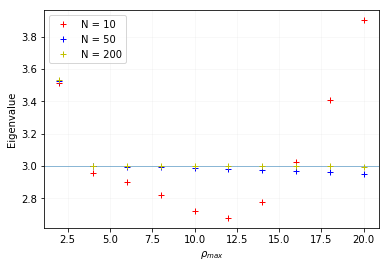

In [8]:
fig, ax = plt.subplots()
ax.axhline(y=3,lw=0.5)
ax.plot(rho_Max[0:10],GroundState1[0:10],'+r', label="N = 10")
ax.plot(rho_Max[0:10],GroundState2[0:10],'+b', label="N = 50")
ax.plot(rho_Max[0:10],GroundState3[0:10],'+y', label="N = 200")
ax.legend()
ax.set_xlabel(r"$\rho_{max}$")
ax.set_ylabel("Eigenvalue")
ax.grid(alpha=0.1)
plt.savefig("GroundStateEigenvalue.png",format="png",dpi=300)

**Then the same plot for the first excited state:**

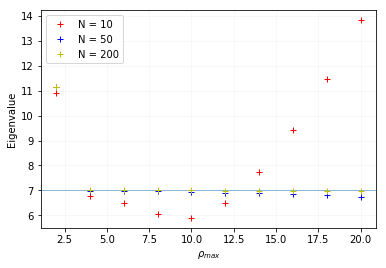

In [9]:
fig2, ax2 = plt.subplots()
ax2.axhline(y=7,lw=0.5)
ax2.plot(rho_Max[0:10],FirstState1[0:10],'+r', label="N = 10")
ax2.plot(rho_Max[0:10],FirstState2[0:10],'+b', label="N = 50")
ax2.plot(rho_Max[0:10],FirstState3[0:10],'+y', label="N = 200")
ax2.legend()
ax2.set_xlabel(r"$\rho_{max}$")
ax2.set_ylabel("Eigenvalue")
ax2.grid(alpha=0.1)
plt.savefig("FirstStateEigenvalue.png",format="png",dpi=300)

**Again for the second excited state:**

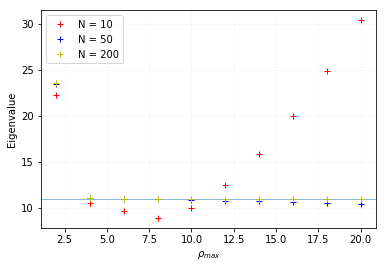

In [10]:
fig3, ax3 = plt.subplots()
ax3.axhline(y=11,lw=0.5)
ax3.plot(rho_Max[0:10],SecondState1[0:10],'+r', label="N = 10")
ax3.plot(rho_Max[0:10],SecondState2[0:10],'+b', label="N = 50")
ax3.plot(rho_Max[0:10],SecondState3[0:10],'+y', label="N = 200")
ax3.legend()
ax3.set_xlabel(r"$\rho_{max}$")
ax3.set_ylabel("Eigenvalue")
ax3.grid(alpha=0.1)
plt.savefig("SecondStateEigenvalue.png",format="png",dpi=300)

**Lastly for the third excited state:**

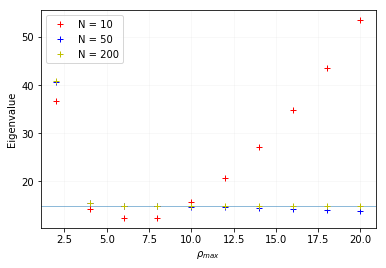

In [11]:
fig4, ax4 = plt.subplots()
ax4.axhline(y=15,lw=0.5)
ax4.plot(rho_Max[0:10],ThirdState1[0:10],'+r', label="N = 10")
ax4.plot(rho_Max[0:10],ThirdState2[0:10],'+b', label="N = 50")
ax4.plot(rho_Max[0:10],ThirdState3[0:10],'+y', label="N = 200")
ax4.legend()
ax4.set_xlabel(r"$\rho_{max}$")
ax4.set_ylabel("Eigenvalue")
ax4.grid(alpha=0.1)
plt.savefig("ThirdStateEigenvalue.png",format="png",dpi=300)

**Checking how many integration points we need to be within four leading decimal points after the comma.**

In [12]:
rho_0 = 0
rho_max = 15
N = 3000
D, Mask, rho = createMatrix(rho_0,rho_max,N)

**For $\rho_{max} = 15$ 3000 integration points are sufficient for the numercal eigenvalue to be within four leading decimal points after the comma compared to analytical eigenvalues. Here numpy was used for such a large matrix.**

In [13]:
#Use numpy for speed
EigVal_nump, EigVec_nump = np.linalg.eig(D)
#print(EigVal_nump)
idx = EigVal_nump.argsort()[::1]
#print(idx)
EigVal_nump = EigVal_nump[idx]
EigVec_nump = EigVec_nump[:,idx]
print(EigVal_nump[0:4])

[ 2.99999219  6.99996096 10.99990475 14.99982355]


## Quantum dots in three dimensions, two electrons

Our equation now reads:

$$-\frac{d^2}{d\rho^2}\phi(\rho) + \omega_r^2\rho^2\phi(\rho) + \frac{1}{\rho} = \lambda\phi(\rho)$$

In [14]:
#Set up a new function to create the matrix with additional term to the diagonal
#Setting up the matrix
#@jit(nopython=True)
def createMatrix3(rhoMin,rhoMax,N,omegaR):
    h = (rhoMax - rhoMin)/(N+1)
    D = np.zeros((N,N))
    Mask = np.ones((N,N),dtype=bool)
    #x = np.linspace(0+h,1-h,n)
    for i in range(N):
        for l in range(N):
            if i == l:
                rho_i = rho_0 + (i+1)*h
                D[i,l] = 2/(h**2) + (rho_i**2)*(omegaR**2) + 1/rho_i#additional term on the diagonal
                Mask[i,l] = False
            if ((i-l) == 1) or ((i-l) == -1):
                D[i,l] = -1/(h**2)
    return D, Mask

In [15]:
rho_0 = 0
rho_max = 15
N = 200
#omega_r = 0.01 
D1, Mask = createMatrix3(rho_0,rho_max,N,0.01)
#omega_r = 0.5 
D2, Mask = createMatrix3(rho_0,rho_max,N,0.5)
#omega_r = 1 
D3, Mask = createMatrix3(rho_0,rho_max,N,1.0)
#omega_r = 5.0 
D4, Mask = createMatrix3(rho_0,rho_max,N,5.0)

**Solving the equation:**

In [16]:
#omega_r = 0.01 
D_out, EigVal3, counter = Jacobi_method2(D1,1e-10,Mask)
EigVal3.sort()
print('omega_r = 0.01 ',EigVal3[0:3],counter)

#omega_r = 0.5
D_out, EigVal3, counter = Jacobi_method2(D2,1e-10,Mask)
EigVal3.sort()
print('omega_r = 0.5 ',EigVal3[0:3],counter)

#omega_r = 1
D_out, EigVal3, counter = Jacobi_method2(D3,1e-10,Mask)
EigVal3.sort()
print('omega_r = 1.0 ',EigVal3[0:3],counter)

#omega_r = 5.0
D_out, EigVal3, counter = Jacobi_method2(D4,1e-10,Mask)
EigVal3.sort()
print('omega_r = 5.0 ',EigVal3[0:3],counter)

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


omega_r = 0.01  [0.18612443 0.36480978 0.6165887 ] 69034
omega_r = 0.5  [2.22967321 4.13243096 6.06893772] 67541
omega_r = 1.0  [ 4.05605181  7.90130833 11.79872033] 66514
omega_r = 5.0  [17.40298741 36.85597169 56.32614061] 40826


**Check two value againts article:**

In [17]:
N = 200
D1, Mask = createMatrix3(rho_0,rho_max,N,0.25)
#omega_r = 0.25 - In article corresponds to eigenvalue 1.250
D_out, EigVal3, counter = Jacobi_method2(D1,1e-10,Mask)
EigVal3.sort()
print('omega_r = 0.25 ',EigVal3[0:3],counter)

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


omega_r = 0.25  [1.24989238 2.18962328 3.14930871] 68640


In [18]:
#omega_r = 0.05 - In article corresponds to eigenvalue 0.1750*2
D2, Mask = createMatrix3(rho_0,rho_max,N,0.05)
D_out, EigVal3, counter = Jacobi_method2(D2,1e-10,Mask)
EigVal3.sort()
print('omega_r = 0.05 ',EigVal3[0:3],counter)
print(0.1750*2)

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars


omega_r = 0.05  [0.35098818 0.54856229 0.79953868] 69226
0.35


## Additional functions that where not used:

In [19]:
#Original function to find the largest nondiagonal element
@jit
def largest_nonDiag(A):
    #Masking diagonal elements and finding the max value of the off-diagonal
    mask = np.ones(A.shape, dtype=bool)
    np.fill_diagonal(mask,0)
    maxValue = np.amax(abs(A[mask]))
    maxValueIndex = np.where(abs(A) == maxValue)
    #taking the lowest index in case has more than one maximum element
    maxValueIndexRow = maxValueIndex[0][0]#row
    k = maxValueIndexRow
    maxValueIndexColumn = maxValueIndex[1][0]#column
    l = maxValueIndexColumn
    #Quick fix to not be choosing the diagonal element
    counter = 1
    while k == l:
        maxValueIndexRow = maxValueIndex[0][counter]#row
        k = maxValueIndexRow
        maxValueIndexColumn = maxValueIndex[1][counter]#column
        l = maxValueIndexColumn
        counter += 1
    #We need to check if the largest element is in the lower triangle and then change indices
    if k > l:
        temp = k
        k = l
        l = temp
        
    return k,l, maxValue

#First version of the Jacobi_method function
#@jit - Prófa kannski að gera sér fall fyrir while lúppu til að flýta fyrir reikningum
def Jacobi_method(A,epsilon):
    #epsilon is the tolerance
    A_temp = A#To not be overwriting every time
    k, l, maxValue = largest_nonDiag2(A_temp,Mask)
    #setting up the algo itself
    while maxValue > epsilon:
        tau = (A_temp[l,l]-A_temp[k,k])/(2*A_temp[k,l])
        #Finding the smaller root
        t1 = -1/(-tau-np.sqrt(1 + tau**2))
        t2 = -1/(-tau+np.sqrt(1 + tau**2))
        if abs(t1) > abs(t2):
            tan_theta = t2
        else:
            tan_theta = t1
        cos_theta = 1/np.sqrt((1 + tan_theta**2))
        sin_theta = tan_theta*cos_theta
        #Setting up matrix S
        S = np.identity(int(A_temp.shape[0]))
        S[k,k] = cos_theta
        S[l,l] = cos_theta
        S[k,l] = sin_theta
        S[l,k] = -sin_theta
        S_transpose = S.transpose()
        A_temp = np.matmul(S_transpose,np.matmul(A_temp,S))
        #Masking diagonal elements and finding the max value of the off-diagonal
        k,l,maxValue = largest_nonDiag2(A_temp,Mask)
        
        #Setting the eigenvalues to a vector
        eigval = np.zeros(A_temp.shape[0])
        for i in range(A_temp.shape[0]):
            for m in range(A_temp.shape[0]):
                if i == m:
                    eigval[m] = A_temp[i,m]
    
    return A_temp, eigval